# Benchmarking BNNs

Import necessary libraries:

In [1]:
import pickle
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_score, recall_score, brier_score_loss, log_loss, f1_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.isotonic import IsotonicRegression
import jax.numpy as jnp
from numpyro.infer import Predictive
import numpyro
import jax.random as rand
import numpyro.distributions as dist
from sklearn.calibration import calibration_curve

Set paths for results:

In [2]:
results_dir = 'results'
log_path = f'{results_dir}/experiment_log.csv'
metrics_path = f'{results_dir}/evaluation_metrics.csv'

Load experiment logs and evaluation metrics, then merge:

In [3]:
log_df = pd.read_csv(log_path)
metrics_df = pd.read_csv(metrics_path)
results_df = pd.merge(log_df, metrics_df, on='id', how='inner')

Keep only successful runs:

In [4]:
results_df = results_df[results_df['status'] == 'success']

Raise error if no successful runs exist:

In [5]:
if results_df.empty:
    raise ValueError('No completed BNN runs found.')

Identify the run with the highest F1 score:

In [6]:
best_row = results_df.loc[results_df['f1'].idxmax()]

Display best row:

In [7]:
best_row

id                  mcmc_NUTS_w14_p0.1
method                            mcmc
kernel                            NUTS
width                               14
precision_prior                    0.1
duration_seconds               2370.93
status                         success
guide                              NaN
precision                     0.960894
recall                        0.955556
f1                            0.958217
log_loss                      0.038102
brier                         0.011091
ece                            0.00971
prec_mean                      0.00533
prec_median                   0.005198
prec_ci_lower                 0.002034
prec_ci_upper                 0.009459
Name: 7, dtype: object

Extract configuration of the best run:

In [8]:
best_config = {
    'id': best_row['id'],
    'f1': best_row['f1'],
    'width': int(best_row['width']),
    'precision_prior': best_row['precision_prior'],
    'kernel': best_row['kernel'],
    'guide': best_row['guide']
}

Print configuration of the best BNN run:

In [9]:
print(f'Best BNN run:\n{best_config}')

Best BNN run:
{'id': 'mcmc_NUTS_w14_p0.1', 'f1': np.float64(0.958217270194986), 'width': 14, 'precision_prior': np.float64(0.1), 'kernel': 'NUTS', 'guide': nan}


Extract width and prior precision for the neural network:

In [10]:
width = best_config['width']
precision_prior = best_config['precision_prior']

Load processed training and validation datasets:

In [11]:
train = pd.read_csv('data/processed/train.csv')
val = pd.read_csv('data/processed/validation.csv')

Separate features and labels for training and validation sets:

In [12]:
y_train = train['label'].values
X_train = train.drop(['label'], axis=1).values

y_val = val['label'].values
X_val = val.drop(['label'], axis=1).values

Convert training and validation data to tensors:

In [13]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)

## Train classifiers

### Neural Network (NN)

Define a simple feedforward neural network with one hidden layer:

In [14]:
class NN(nn.Module):
    def __init__(self, input_dim, hidden_dim, precision_prior):
        super().__init__()
        self.precision_prior = precision_prior
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, 1)
        self.sigmoid = nn.Sigmoid()
        
        self._init_weights()

    def _init_weights(self):
        fan_in1 = self.fc1.in_features
        std1 = np.sqrt(1.0 / (self.precision_prior * (fan_in1)))
        nn.init.normal_(self.fc1.weight, mean=0.0, std=std1)
        nn.init.normal_(self.fc1.bias, mean=0.0, std=std1)

        fan_in2 = self.fc2.in_features
        std2 = np.sqrt(1.0 / (self.precision_prior * (fan_in2)))
        nn.init.normal_(self.fc2.weight, mean=0.0, std=std2)
        nn.init.normal_(self.fc2.bias, mean=0.0, std=std2)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return self.sigmoid(x)

Set random seeds for reproducibility:

In [15]:
torch.manual_seed(123)
np.random.seed(123)
random.seed(123)

Initialize NN model, loss function, optimizer, and training parameters:

In [16]:
input_dim = X_train.shape[1]
nn_model = NN(input_dim, width, precision_prior)
criterion = nn.BCELoss()
optimizer = optim.Adam(nn_model.parameters(), lr=1e-3)
batch_size = 256
epochs = 20

Initialize lists to store training history:

In [17]:
nn_train_loss_history = []
nn_val_loss_history = []
nn_train_f1_history = []
nn_val_f1_history = []

Early stopping parameters:

In [18]:
patience = 5  
best_val_f1 = -np.inf
epochs_no_improve = 0

Training loop with mini-batch gradient descent and early stopping:

In [19]:
for epoch in range(epochs):
    nn_model.train()
    permutation = torch.randperm(X_train_tensor.size()[0])
    epoch_loss = 0
    all_preds = []
    all_labels = []

    for i in range(0, X_train_tensor.size()[0], batch_size):
        indices = permutation[i:i + batch_size]
        batch_x, batch_y = X_train_tensor[indices], y_train_tensor[indices]

        optimizer.zero_grad()
        outputs = nn_model(batch_x).squeeze()
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        preds = (outputs.detach() > 0.5).long()
        all_preds.append(preds)
        all_labels.append(batch_y.long())

    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)
    train_f1 = f1_score(all_labels.cpu(), all_preds.cpu())
    train_loss = epoch_loss / (X_train_tensor.size()[0] // batch_size)

    nn_model.eval()
    with torch.no_grad():
        val_outputs = nn_model(X_val_tensor).squeeze()
        val_loss = criterion(val_outputs, y_val_tensor).item()
        val_preds = (val_outputs > 0.5).long()
        val_f1 = f1_score(y_val_tensor.cpu(), val_preds.cpu())

    nn_train_loss_history.append(train_loss)
    nn_val_loss_history.append(val_loss)
    nn_train_f1_history.append(train_f1)
    nn_val_f1_history.append(val_f1)

    print(f'Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.4f}, Train F1: {train_f1:.4f}, Val Loss: {val_loss:.4f}, Val F1: {val_f1:.4f}')

    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        epochs_no_improve = 0
        best_model_state = nn_model.state_dict()  
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"Early stopping at epoch {epoch+1}. Best Val F1: {best_val_f1:.4f}")
            nn_model.load_state_dict(best_model_state)  
            break

Epoch 1/20 - Train Loss: 0.5376, Train F1: 0.6904, Val Loss: 0.2767, Val F1: 0.8667
Epoch 2/20 - Train Loss: 0.1915, Train F1: 0.8674, Val Loss: 0.1270, Val F1: 0.8922
Epoch 3/20 - Train Loss: 0.1304, Train F1: 0.8738, Val Loss: 0.1104, Val F1: 0.9003
Epoch 4/20 - Train Loss: 0.1190, Train F1: 0.8758, Val Loss: 0.1030, Val F1: 0.9003
Epoch 5/20 - Train Loss: 0.1135, Train F1: 0.8758, Val Loss: 0.0996, Val F1: 0.9003
Epoch 6/20 - Train Loss: 0.1101, Train F1: 0.8759, Val Loss: 0.0970, Val F1: 0.8970
Epoch 7/20 - Train Loss: 0.1076, Train F1: 0.8758, Val Loss: 0.0962, Val F1: 0.8949
Epoch 8/20 - Train Loss: 0.1059, Train F1: 0.8784, Val Loss: 0.0930, Val F1: 0.8970
Early stopping at epoch 8. Best Val F1: 0.9003


Plot training and validation loss and F1 score per epoch:

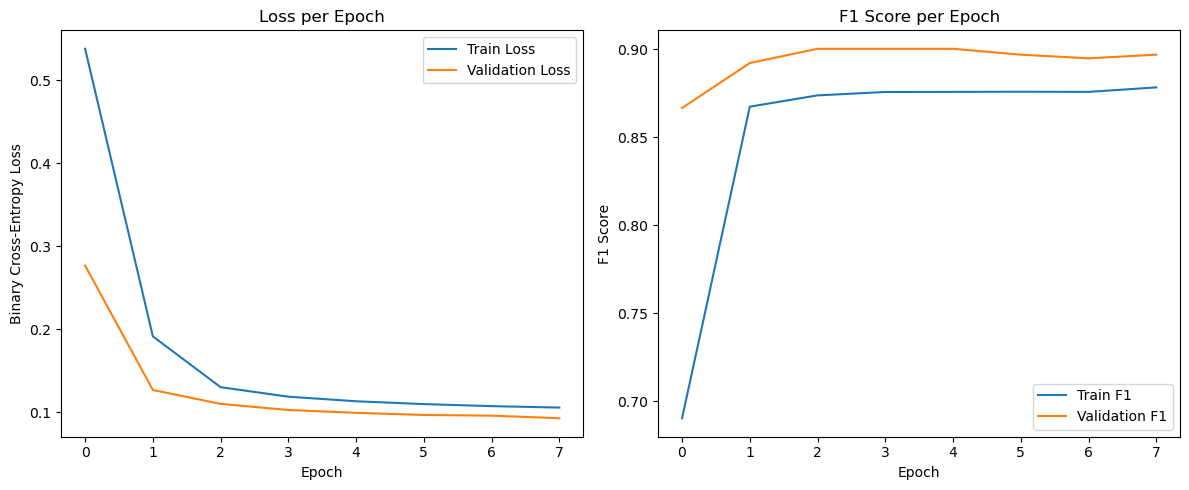

In [20]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(nn_train_loss_history, label='Train Loss')
plt.plot(nn_val_loss_history, label='Validation Loss')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Binary Cross-Entropy Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(nn_train_f1_history, label='Train F1')
plt.plot(nn_val_f1_history, label='Validation F1')
plt.title('F1 Score per Epoch')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend()

plt.tight_layout()
plt.show()

Evaluate model on validation set:

In [21]:
nn_model.eval()
with torch.no_grad():
    val_outputs = nn_model(X_val_tensor).squeeze()
    val_probs = val_outputs.cpu().numpy()  
    val_preds = (val_outputs > 0.5).long().cpu().numpy()  
    y_val_np = y_val_tensor.cpu().numpy()  

val_log_loss = log_loss(y_val_np, val_probs)
val_brier_score = brier_score_loss(y_val_np, val_probs)
val_f1 = f1_score(y_val_np, val_preds)

print(f'Validation Log Loss: {val_log_loss:.4f}')
print(f'Validation Brier Score: {val_brier_score:.4f}')
print(f'Validation F1 Score: {val_f1:.4f}')

Validation Log Loss: 0.0930
Validation Brier Score: 0.0244
Validation F1 Score: 0.8970


### Calibrated NN

Define a class for a calibrated neural network using isotonic regression for probability calibration:

In [22]:
class CalibratedNN:
    def __init__(self, input_dim, hidden_dim, precision_prior, lr=1e-3, batch_size=256, epochs=20, device='cpu'):
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.precision_prior = precision_prior
        self.lr = lr
        self.batch_size = batch_size
        self.epochs = epochs
        self.device = device
        self.models = []
        self.calibrators = []

    def _init_model(self):
        model = NN(self.input_dim, self.hidden_dim, self.precision_prior).to(self.device)
        optimizer = optim.Adam(model.parameters(), lr=self.lr)
        return model, optimizer

    def _train_one_model(self, model, optimizer, X_train, y_train):
        criterion = nn.BCELoss()
        model.train()
        for epoch in range(self.epochs):
            permutation = torch.randperm(X_train.size()[0])
            for i in range(0, X_train.size()[0], self.batch_size):
                indices = permutation[i:i + self.batch_size]
                batch_x, batch_y = X_train[indices], y_train[indices]

                optimizer.zero_grad()
                outputs = model(batch_x).squeeze()
                loss = criterion(outputs, batch_y)
                loss.backward()
                optimizer.step()
        return model

    def fit(self, X_tensor, y_tensor):
        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)
        X_np = X_tensor.cpu().numpy()
        y_np = y_tensor.cpu().numpy()

        for train_idx, cal_idx in skf.split(X_np, y_np):
            X_train, X_cal = X_tensor[train_idx], X_tensor[cal_idx]
            y_train, y_cal = y_tensor[train_idx], y_tensor[cal_idx]

            model, optimizer = self._init_model()
            model = self._train_one_model(model, optimizer, X_train, y_train)

            model.eval()
            with torch.no_grad():
                probs_cal = model(X_cal).squeeze().cpu().numpy()
                y_cal_np = y_cal.cpu().numpy()

            calibrator = IsotonicRegression(out_of_bounds='clip')
            calibrator.fit(probs_cal, y_cal_np)

            self.models.append(model)
            self.calibrators.append(calibrator)

    def predict_proba(self, X_tensor):
        calibrated_probs = []

        for model, calibrator in zip(self.models, self.calibrators):
            model.eval()
            with torch.no_grad():
                probs = model(X_tensor.to(self.device)).squeeze().cpu().numpy()
            probs = calibrator.predict(probs)
            calibrated_probs.append(probs)

        return np.mean(calibrated_probs, axis=0)

    def predict(self, X_tensor, threshold=0.5):
        probs = self.predict_proba(X_tensor)
        return (probs > threshold).astype(int)

Instantiate and train calibrated NN:

In [23]:
calibrated_nn = CalibratedNN(
  input_dim, hidden_dim=10, precision_prior=precision_prior, epochs=10
)
calibrated_nn.fit(X_train_tensor, y_train_tensor)

Evaluate on validation:

In [24]:
cal_probs = calibrated_nn.predict_proba(X_val_tensor)

# Predict classes
cal_preds = calibrated_nn.predict(X_val_tensor)

# Evaluate
print('Calibrated Log Loss:', log_loss(y_val_tensor.cpu().numpy(), cal_probs))
print('Calibrated Brier Score:', brier_score_loss(y_val_tensor.cpu().numpy(), cal_probs))
print('Calibrated F1 Score:', f1_score(y_val_tensor.cpu().numpy(), cal_preds))

Calibrated Log Loss: 0.089057743015046
Calibrated Brier Score: 0.024100770043635443
Calibrated F1 Score: 0.9112426035502958


### Gradient Boosted Decision Tree (GBDT)

Define GBDT model:

In [25]:
gb_model = GradientBoostingClassifier(
    n_estimators=1000,
    max_depth=3,
    subsample=0.8,
    min_samples_split=10,
    random_state=123
)

Fit GBDT on training data:

In [26]:
gb_model.fit(X_train, y_train)

,loss,'log_loss'
,learning_rate,0.1
,n_estimators,1000
,subsample,0.8
,criterion,'friedman_mse'
,min_samples_split,10
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_depth,3
,min_impurity_decrease,0.0
,init,None


Evaluate on validation:

In [27]:
val_probs = gb_model.predict_proba(X_val)[:, 1]
val_preds = (val_probs > 0.5).astype(int)

f1 = f1_score(y_val, val_preds)
logloss = log_loss(y_val, val_probs)
brier = brier_score_loss(y_val, val_probs)

print(f'F1 Score: {f1:.4f}')
print(f'Log Loss: {logloss:.4f}')
print(f'Brier Score: {brier:.4f}')

F1 Score: 0.9718
Log Loss: 0.0304
Brier Score: 0.0085


### Calibrated GBDT

Calibrated GBDT model using isotonic regression:

In [85]:
calibrated_gb = CalibratedClassifierCV(
    estimator=gb_model,
    method='isotonic',  
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=123)
)

Fit calibrated GBDT:

In [86]:
calibrated_gb.fit(X_train, y_train)

,estimator,GradientBoost...subsample=0.8)
,method,'isotonic'
,cv,StratifiedKFo... shuffle=True)
,n_jobs,None
,ensemble,'auto'
,loss,'log_loss'
,learning_rate,0.1
,n_estimators,1000
,subsample,0.8
,criterion,'friedman_mse'
,min_samples_split,10


Evaluate on validation:

In [87]:
# Predict probabilities and classes on validation data
val_probs = calibrated_gb.predict_proba(X_val)[:, 1]
val_preds = (val_probs > 0.5).astype(int)

# Evaluate metrics
f1 = f1_score(y_val, val_preds)
logloss = log_loss(y_val, val_probs)
brier = brier_score_loss(y_val, val_probs)

print(f'Calibrated GB - F1 Score: {f1:.4f}')
print(f'Calibrated GB - Log Loss: {logloss:.4f}')
print(f'Calibrated GB - Brier Score: {brier:.4f}')

Calibrated GB - F1 Score: 0.9775
Calibrated GB - Log Loss: 0.0290
Calibrated GB - Brier Score: 0.0080


## Benchmarking on test

Load testing dataset:

In [31]:
test = pd.read_csv('data/processed/test.csv')

In [32]:
X_test = test.drop(['label'], axis=1).values
y_test = test['label'].values

Function to compute Expected Calibration Error (ECE):

In [33]:
def compute_ece(probabilities, true_labels, n_bins=10):
    bin_edges = np.linspace(0.0, 1.0, n_bins + 1)
    bin_indices = np.digitize(probabilities, bin_edges) - 1

    ece = 0.0
    for i in range(n_bins):
        bin_mask = bin_indices == i
        if np.any(bin_mask):
            bin_confidence = probabilities[bin_mask].mean()
            bin_accuracy = true_labels[bin_mask].mean()
            ece += np.abs(bin_confidence - bin_accuracy) * bin_mask.mean()
    return ece

Function to evaluate model with multiple metrics:

In [34]:
def evaluate_model(model_name, dataset_name, y_true, probs, preds, results_list):
    results_list.append({
        'model': model_name,
        'dataset': dataset_name,
        'metric': 'log_loss',
        'value': log_loss(y_true, probs)
    })
    results_list.append({
        'model': model_name,
        'dataset': dataset_name,
        'metric': 'brier',
        'value': brier_score_loss(y_true, probs)
    })
    results_list.append({
        'model': model_name,
        'dataset': dataset_name,
        'metric': 'f1',
        'value': f1_score(y_true, preds)
    })
    results_list.append({
        'model': model_name,
        'dataset': dataset_name,
        'metric': 'precision',
        'value': precision_score(y_true, preds)
    })
    results_list.append({
        'model': model_name,
        'dataset': dataset_name,
        'metric': 'recall',
        'value': recall_score(y_true, preds)
    })
    results_list.append({
        'model': model_name,
        'dataset': dataset_name,
        'metric': 'ece',
        'value': compute_ece(np.array(probs), np.array(y_true))
    })

### BNN

In [35]:
best_bnn = best_row['id']

with open(f'results/bnn/{best_bnn}_samples.pkl', 'rb') as f:
    bnn_samples = pickle.load(f)

In [36]:
for k, v in bnn_samples.items():
  if v.ndim >= 2 and v.shape[0] <= 10 and v.shape[0] > 1: 
    bnn_samples[k] = v.reshape(-1, *v.shape[2:])

In [37]:
X_train_jax = jnp.array(X_train)
X_val_jax = jnp.array(X_val)
X_test_jax = jnp.array(X_test)

In [38]:
precision_prior_map = {
    0.01: (2.0, 200.0),  
    0.1: (2.0, 20.0),   
    1.0: (2.0, 2.0)   
}

In [39]:
def bnn_model(X, y=None, hidden_dim=10, precision_prior=1.0):
    n, m = X.shape
    alpha, beta = precision_prior_map[precision_prior]
    precision_nn = numpyro.sample('precision_nn', dist.Gamma(alpha, beta))

    # First layer: biases and weights
    with numpyro.plate('l1_hidden', hidden_dim):
        b1 = numpyro.sample(
            'nn_b1', dist.Normal(0.0, jnp.sqrt(1.0 / (precision_nn*m)))
        )
        with numpyro.plate('l1_feat', m):
            w1 = numpyro.sample(
                'nn_w1', dist.Normal(0.0, jnp.sqrt(1.0 / (precision_nn*m)))
            )

    # Second (output) layer: weights and bias
    with numpyro.plate('l2_hidden', hidden_dim):
        w2 = numpyro.sample(
            'nn_w2', dist.Normal(0.0, jnp.sqrt(1.0 / (precision_nn*hidden_dim)))
        )
    b2 = numpyro.sample(
        'nn_b2', dist.Normal(0.0, jnp.sqrt(1.0 / (precision_nn*hidden_dim)))
    )

    # Forward pass with ReLU activation
    hidden = jnp.maximum(X @ w1 + b1, 0)
    logits = hidden @ w2 + b2

    # Bernoulli likelihood
    with numpyro.plate('data', n):
        numpyro.sample('obs', dist.Bernoulli(logits=logits), obs=y)

In [40]:
predictive = Predictive(
  bnn_model, posterior_samples=bnn_samples, return_sites=['obs'], parallel=True
)

In [41]:
key = rand.PRNGKey(123)

In [42]:
train_probs_samples_bnn = predictive(
  key, X=X_train_jax, hidden_dim=width, precision_prior=precision_prior
)
val_probs_samples_bnn = predictive(
  key, X=X_val_jax, hidden_dim=width, precision_prior=precision_prior
)
test_probs_samples_bnn = predictive(
  key, X=X_test_jax, hidden_dim=width, precision_prior=precision_prior
)

In [43]:
def get_mean_prediction(predictive_samples):
    probs = predictive_samples['obs']
    mean_probs = jnp.mean(probs, axis=0)
    return np.array(mean_probs)

In [44]:
train_probs_bnn = get_mean_prediction(train_probs_samples_bnn)
val_probs_bnn = get_mean_prediction(val_probs_samples_bnn)
test_probs_bnn = get_mean_prediction(test_probs_samples_bnn)

In [45]:
train_preds_bnn = (train_probs_bnn > 0.5).astype(int)
val_preds_bnn = (val_probs_bnn > 0.5).astype(int)
test_preds_bnn = (test_probs_bnn > 0.5).astype(int)

In [46]:
results = []

In [47]:
evaluate_model('bnn', 'train', y_train, train_probs_bnn, train_preds_bnn, results)
evaluate_model('bnn', 'val', y_val, val_probs_bnn, val_preds_bnn, results)
evaluate_model('bnn', 'test', y_test, test_probs_bnn, test_preds_bnn, results)

### NN

In [48]:
nn_model.eval()
with torch.no_grad():
    train_probs_nn = nn_model(X_train_tensor).squeeze().cpu().numpy()
    train_preds_nn = (train_probs_nn > 0.5).astype(int)
evaluate_model('nn', 'train', y_train, train_probs_nn, train_preds_nn, results)

with torch.no_grad():
    val_probs_nn = nn_model(X_val_tensor).squeeze().cpu().numpy()
    val_preds_nn = (val_probs_nn > 0.5).astype(int)
evaluate_model('nn', 'val', y_val, val_probs_nn, val_preds_nn, results)

X_test = test.drop(['label'], axis=1).values
y_test = test['label'].values
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
with torch.no_grad():
    test_probs_nn = nn_model(X_test_tensor).squeeze().cpu().numpy()
    test_preds_nn = (test_probs_nn > 0.5).astype(int)
evaluate_model('nn', 'test', y_test, test_probs_nn, test_preds_nn, results)

### Calibrated NN

In [49]:
train_probs_calnn = calibrated_nn.predict_proba(X_train_tensor)
train_preds_calnn = calibrated_nn.predict(X_train_tensor)
evaluate_model('calibrated_nn', 'train', y_train, train_probs_calnn, train_preds_calnn, results)

val_probs_calnn = calibrated_nn.predict_proba(X_val_tensor)
val_preds_calnn = calibrated_nn.predict(X_val_tensor)
evaluate_model('calibrated_nn', 'val', y_val, val_probs_calnn, val_preds_calnn, results)

test_probs_calnn = calibrated_nn.predict_proba(X_test_tensor)
test_preds_calnn = calibrated_nn.predict(X_test_tensor)
evaluate_model('calibrated_nn', 'test', y_test, test_probs_calnn, test_preds_calnn, results)

### GBDT

In [50]:
train_probs_gb = gb_model.predict_proba(X_train)[:, 1]
train_preds_gb = (train_probs_gb > 0.5).astype(int)
evaluate_model('gbdt', 'train', y_train, train_probs_gb, train_preds_gb, results)

val_probs_gb = gb_model.predict_proba(X_val)[:, 1]
val_preds_gb = (val_probs_gb > 0.5).astype(int)
evaluate_model('gbdt', 'val', y_val, val_probs_gb, val_preds_gb, results)

test_probs_gb = gb_model.predict_proba(X_test)[:, 1]
test_preds_gb = (test_probs_gb > 0.5).astype(int)
evaluate_model('gbdt', 'test', y_test, test_probs_gb, test_preds_gb, results)

### Calibrated GBDT

In [51]:
train_probs_calgb = calibrated_gb.predict_proba(X_train)[:, 1]
train_preds_calgb = (train_probs_calgb > 0.5).astype(int)
evaluate_model('calibrated_gbdt', 'train', y_train, train_probs_calgb, train_preds_calgb, results)

val_probs_calgb = calibrated_gb.predict_proba(X_val)[:, 1]
val_preds_calgb = (val_probs_calgb > 0.5).astype(int)
evaluate_model('calibrated_gbdt', 'val', y_val, val_probs_calgb, val_preds_calgb, results)

test_probs_calgb = calibrated_gb.predict_proba(X_test)[:, 1]
test_preds_calgb = (test_probs_calgb > 0.5).astype(int)
evaluate_model('calibrated_gbdt', 'test', y_test, test_probs_calgb, test_preds_calgb, results)

In [53]:
bench_df = pd.DataFrame(results)
bench_df.to_csv('results/benchmarking.csv', index=False)

In [54]:
bench_df

,model,dataset,metric,value
0,bnn,train,log_loss,0.046889
1,bnn,train,brier,0.012481
2,bnn,train,f1,0.954322
3,bnn,train,precision,0.969436
4,bnn,train,recall,0.939672
...,...,...,...,...
85,calibrated_gbdt,test,brier,0.005284
86,calibrated_gbdt,test,f1,0.981248
87,calibrated_gbdt,test,precision,0.985444
88,calibrated_gbdt,test,recall,0.977087


#### Calibration curves plot

In [55]:
calibration_curve_data = {
    'BNN': (test_probs_bnn, y_test),
    'NN': (test_probs_nn, y_test),
    'Cal. NN': (test_probs_calnn, y_test),
    'GBDC': (test_probs_gb, y_test),
    'Cal. GBDT': (test_probs_calgb, y_test),
}

In [56]:
calibration_curve_points = []

In [57]:
sns.set_style("white")

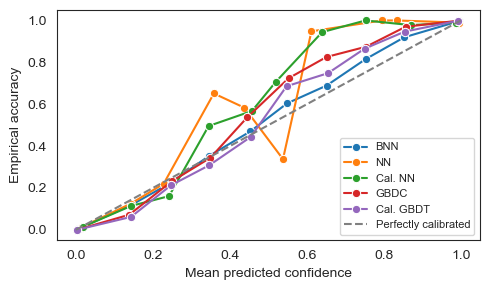

In [58]:
for model_name, (probs, y_true) in calibration_curve_data.items():
    prob_true, prob_pred = calibration_curve(
        y_true, probs, n_bins=10, strategy='uniform'
    )
    df_temp = pd.DataFrame({
        'Mean predicted confidence': prob_pred,
        'Empirical accuracy': prob_true,
        'Model': model_name
    })
    calibration_curve_points.append(df_temp)

calibration_df = pd.concat(calibration_curve_points, ignore_index=True)

plt.figure(figsize=(5, 3))
sns.lineplot(
    data=calibration_df,
    x='Mean predicted confidence',
    y='Empirical accuracy',
    hue='Model',
    marker='o'
)

plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly calibrated')

plt.xlabel('Mean predicted confidence')
plt.ylabel('Empirical accuracy')
plt.legend(loc='lower right', fontsize=8)
plt.tight_layout()

plt.savefig(
    "figures/calibration_curves.png", dpi=300, 
    bbox_inches="tight"
)
plt.show()

#### Histograms of predicted probabilities

In [59]:
pred_probs_data = {
    'BNN': test_probs_bnn,
    'NN': test_probs_nn,
    'Cal. NN': test_probs_calnn,
    'GBDT': test_probs_gb,
    'Cal. GBDT': test_probs_calgb
}

In [60]:
hist_data = []
for model_name, probs in pred_probs_data.items():
    hist_data.append(pd.DataFrame({
        'Predicted probability': probs,
        'Model': model_name
    }))
hist_df = pd.concat(hist_data, ignore_index=True)

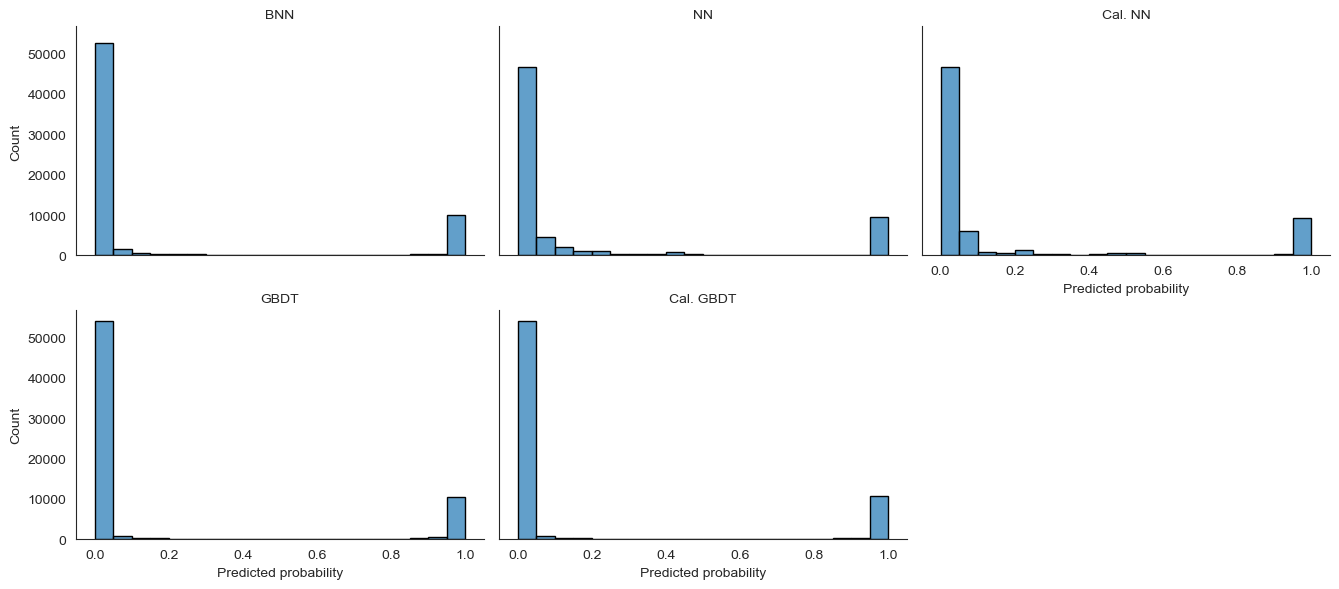

In [61]:
g = sns.FacetGrid(
    hist_df, col="Model", col_wrap=3, sharex=True, sharey=True, height=3, 
    aspect=1.5
)
g.map_dataframe(
    sns.histplot,
    x="Predicted probability",
    bins=np.linspace(0, 1, 21),
    edgecolor="black",
    alpha=0.7
)

g.set_titles("{col_name}")
g.set_axis_labels("Predicted probability", "Count")

plt.tight_layout()

plt.savefig(
    "figures/pred_probs_hist.png", dpi=300, bbox_inches="tight"
)
plt.show()

#### Benchmarking plot

In [62]:
model_labels = {
    'bnn': 'BNN',
    'nn': 'NN',
    'calibrated_nn': 'Cal. NN',
    'gbdt': 'GBDT',
    'calibrated_gbdt': 'Cal. GBDT'
}

bench_df_plot = bench_df.copy()
bench_df_plot['model'] = (
  bench_df_plot['model'].map(model_labels).fillna(bench_df_plot['model'])
)

metric_labels = {
    'brier': 'Brier Score',
    'ece': 'ECE',
    'log_loss': 'Log Loss',
    'f1': 'F1',
    'precision': 'Precision',
    'recall': 'Recall'
}

bench_df_plot['metric'] = (
    bench_df_plot['metric'].map(metric_labels).fillna(bench_df_plot['metric'])
)

In [63]:
bench_df_test = bench_df_plot[bench_df_plot['dataset'] == 'test']

In [64]:
metric_order = [
  'F1',
  'Precision',
  'Recall',
  'Log Loss',
  'Brier Score',
  'ECE'
]

metrics = [m for m in metric_order if m in bench_df_test['metric'].unique()]
n_metrics = len(metrics)

ncols = 3
nrows = (n_metrics + ncols - 1) // ncols

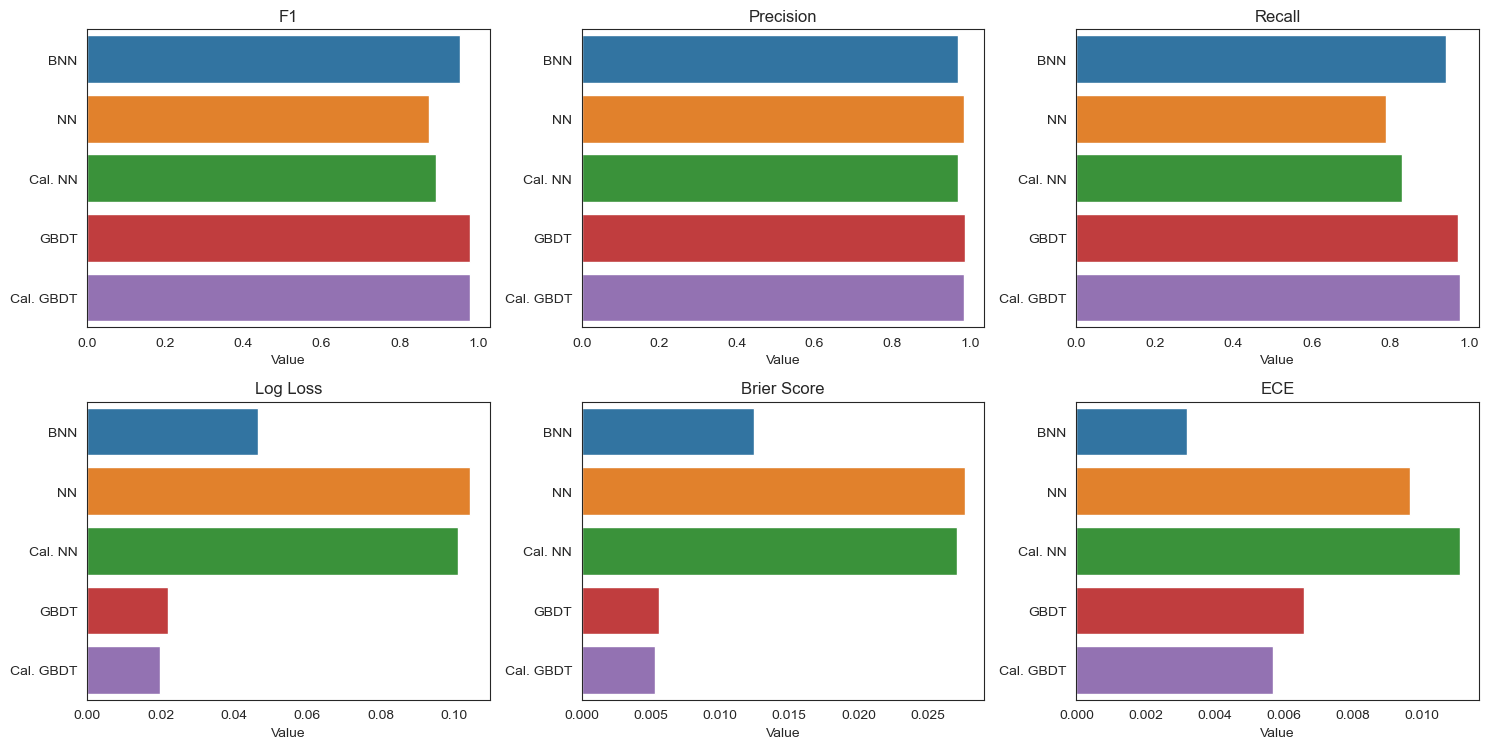

In [65]:
fig, axes = plt.subplots(nrows, ncols, figsize=(5*ncols, 4*nrows), sharey=False)

for ax, metric in zip(axes.flat, metrics):
    sns.barplot(
        data=bench_df_test[bench_df_test['metric']==metric],
        y='model', x='value', hue='model',
        ax=ax, errorbar=None
    )
    ax.set_title(metric)
    ax.set_ylabel('')
    ax.set_xlabel('Value')
    if ax.get_legend() is not None: 
        ax.get_legend().remove()  

for i in range(n_metrics, nrows * ncols):
    axes.flat[i].set_visible(False)

handles, labels = None, None
for ax in axes.flat:
    handles, labels = ax.get_legend_handles_labels()
    if handles: 
        break

if handles:
    fig.legend(
        handles, labels, loc='upper center', ncol=len(labels), frameon=False
    )

plt.tight_layout(rect=[0, 0, 1, 0.95])

plt.savefig(
    "figures/benchmarking.png", dpi=300, bbox_inches="tight"
)

plt.show()